In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [35]:
%%time
def extend(a, b):
    return 1.05 * a - 0.05 * b, 1.05 * b - 0.05 * a

stype = 'pca'
pd.set_option('display.width', 200)
data = pd.read_csv('D://Git//ML_Project//single_test//iris.data', header=None)
#columns = np.array(['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type'])
columns = np.array(['花萼长度', '花萼宽度', '花瓣长度', '花瓣宽度', '类型'])
data.rename(columns = dict(list(zip(np.arange(5), columns))), inplace = True)    #修改data列名并替换
data['类型'] = pd.Categorical(data['类型']).codes 
x = data[columns[:-1]]
y = data[columns[-1]]

Wall time: 4.99 ms


In [36]:
if stype == 'pca':
    pca = PCA(n_components = 2, whiten = True, random_state = 0)
    x = pca.fit_transform(x)
    print('各方向方差：', pca.explained_variance_)
    print('方差所占比例：', pca.explained_variance_ratio_)
    x1_label, x2_label = '组分1', '组分2'
    title = '鸢尾花数据PCA'
else:
    fs = SelectKBest(chi2, k = 2)
    fs.fit(x, y)
    idx = fs.get_support(indices = True)
    print('fs.get_support() = ', idx)
    x = x[columns[idx]]
    x = x.values    # 为下面使用方便，DataFrame转换成ndarray
    x1_label, x2_label = columns[idx]
    title = '鸢尾花数据特征选择'

各方向方差： [4.22484077 0.24224357]
方差所占比例： [0.92461621 0.05301557]


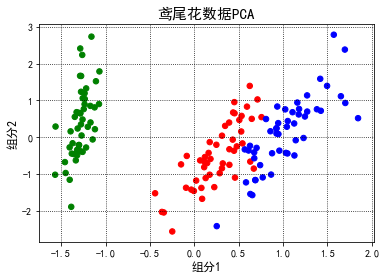

In [37]:
cm_light = mpl.colors.ListedColormap(['#77E0A0', '#FF8080', '#A0A0FF'])
cm_dark = mpl.colors.ListedColormap(['g', 'r', 'b'])
mpl.rcParams['font.sans-serif'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(facecolor = 'w')
plt.scatter(x[:, 0], x[:, 1], s = 30, c = y, marker = 'o', cmap = cm_dark)
plt.grid(b = True, ls = ':', color = 'k')
plt.xlabel(x1_label, fontsize = 12)
plt.ylabel(x2_label, fontsize = 12)
plt.title(title, fontsize = 15)
plt.show()

In [38]:
x, x_test, y, y_test = train_test_split(x, y, test_size = 0.3)
model = Pipeline([
    ('poly', PolynomialFeatures(degree = 2, include_bias = True)),
    ('lr', LogisticRegressionCV(Cs = np.logspace(-3, 4, 8), cv = 5, fit_intercept = False))
])
model.fit(x, y)
print('最优参数', model.get_params('lr')['lr'].C_)
y_hat = model.predict(x)
print('训练级精度：', metrics.accuracy_score(y, y_hat))
y_test_hat = model.predict(x_test)
print('测试集精度：', metrics.accuracy_score(y_test, y_test_hat))

最优参数 [1000.   10.    1.]
训练级精度： 0.9809523809523809
测试集精度： 0.9333333333333333


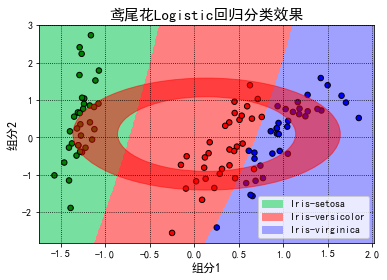

In [39]:
N, M = 500, 500
x1_min, x1_max = extend(x[:, 0].min(), x[:, 0].max())    #第1个主成分——extend
x2_min, x2_max = extend(x[:, 1].min(), x[:, 1].max())    #第2个主成分——extend
t1 = np.linspace(x1_min, x1_max, N)
t2 = np.linspace(x2_min, x2_max, M)
x1, x2 = np.meshgrid(t1, t2)    #生成网格采样点
x_show = np.stack((x1.flat, x2.flat), axis = 1)    #测试点
y_hat = model.predict(x_show)   #预测值
y_hat = y_hat.reshape(x1.shape)    #与输入形状相同
plt.figure(facecolor='w')
plt.pcolormesh(x1, x2, y_hat, cmap = cm_light)    #预测值显示
plt.scatter(x[:, 0], x[:, 1], s=30, c=y, edgecolors='k', cmap=cm_dark)  # 样本绘制
plt.xlabel(x1_label, fontsize = 12)
plt.ylabel(x2_label, fontsize = 12)
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.grid(b=True, ls=':', color='k')
a = mpl.patches.Wedge(((x1_min+x1_max)/2, (x2_min+x2_max)/2), 1.5, 0, 360, width=0.5, alpha=0.5, color='r')
plt.gca().add_patch(a)
patchs = [mpatches.Patch(color='#77E0A0', label='Iris-setosa'),
          mpatches.Patch(color='#FF8080', label='Iris-versicolor'),
          mpatches.Patch(color='#A0A0FF', label='Iris-virginica')]
plt.legend(handles=patchs, fancybox=True, framealpha=0.8, loc='lower right')
plt.title('鸢尾花Logistic回归分类效果', fontsize=15)
plt.show()
